**Mount Drive & set paths**

In [ ]:
# STEP 0: Mount Google Drive and define paths

from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = '/content/drive/MyDrive/Wheat_Leaf_Disease_Project'
SOURCE_ALL   = f'{PROJECT_ROOT}/train'              # you already created this with 3 class folders
SPLITS_ROOT  = f'{PROJECT_ROOT}/splits'             # we will create train/val/test here

print('PROJECT_ROOT:', PROJECT_ROOT)
!ls -la "$SOURCE_ALL"


Mounted at /content/drive
PROJECT_ROOT: /content/drive/MyDrive/Wheat_Leaf_Disease_Project
total 12
drwx------ 2 root root 4096 Aug 14 18:31 renamed_healthy
drwx------ 2 root root 4096 Aug 14 18:33 renamed_Wheat_Leaf_Rust
drwx------ 2 root root 4096 Aug 14 18:33 renamed_Wheat_Loose_Smut


**Create Train/Val/Test (70/15/15) per class**

In [ ]:
# STEP 1: Make clean splits (70/15/15) WITHIN EACH CLASS

import os, shutil, random
from sklearn.model_selection import train_test_split

random.seed(42)

classes = sorted([d for d in os.listdir(SOURCE_ALL) if os.path.isdir(os.path.join(SOURCE_ALL, d))])
print('Classes:', classes)

# create split dirs
for split in ['train','val','test']:
    for c in classes:
        os.makedirs(os.path.join(SPLITS_ROOT, split, c), exist_ok=True)

def is_image(fname):
    ext = os.path.splitext(fname)[1].lower()
    return ext in {'.jpg', '.jpeg', '.png'}

def copy_list(file_list, src_dir, dst_dir):
    for f in file_list:
        src = os.path.join(src_dir, f)
        dst = os.path.join(dst_dir, f)
        if not os.path.exists(dst):  # avoid recopy
            shutil.copy2(src, dst)

# split per class
summary = {}
for c in classes:
    src_dir = os.path.join(SOURCE_ALL, c)
    files   = sorted([f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir,f)) and is_image(f)])

    train_files, temp_files = train_test_split(files, test_size=0.30, random_state=42, shuffle=True)
    val_files,   test_files = train_test_split(temp_files, test_size=0.50, random_state=42, shuffle=True)

    copy_list(train_files, src_dir, os.path.join(SPLITS_ROOT, 'train', c))
    copy_list(val_files,   src_dir, os.path.join(SPLITS_ROOT, 'val',   c))
    copy_list(test_files,  src_dir, os.path.join(SPLITS_ROOT, 'test',  c))

    summary[c] = {
        'total': len(files),
        'train': len(train_files),
        'val':   len(val_files),
        'test':  len(test_files)
    }

summary


Classes: ['renamed_Wheat_Leaf_Rust', 'renamed_Wheat_Loose_Smut', 'renamed_healthy']


{'renamed_Wheat_Leaf_Rust': {'total': 270,
  'train': 189,
  'val': 40,
  'test': 41},
 'renamed_Wheat_Loose_Smut': {'total': 1836,
  'train': 1285,
  'val': 275,
  'test': 276},
 'renamed_healthy': {'total': 2556, 'train': 1789, 'val': 383, 'test': 384}}

**Verify split counts & class balance**

In [ ]:
# STEP 2: Print neat summary table

import pandas as pd, os

rows = []
for c, s in summary.items():
    rows.append([c, s['total'], s['train'], s['val'], s['test']])
df = pd.DataFrame(rows, columns=['Class','Total','Train','Val','Test'])
df.loc['TOTAL'] = ['TOTAL', df['Total'].sum(), df['Train'].sum(), df['Val'].sum(), df['Test'].sum()]
df


,Class,Total,Train,Val,Test
0,renamed_Wheat_Leaf_Rust,270,189,40,41
1,renamed_Wheat_Loose_Smut,1836,1285,275,276
2,renamed_healthy,2556,1789,383,384
TOTAL,TOTAL,4662,3263,698,701


In [ ]:
print(df.to_string(index=False))


                   Class  Total  Train  Val  Test
 renamed_Wheat_Leaf_Rust    270    189   40    41
renamed_Wheat_Loose_Smut   1836   1285  275   276
         renamed_healthy   2556   1789  383   384
                   TOTAL   4662   3263  698   701


**Build generators (train/val/test) + show a quick batch**

In [ ]:
# STEP 3: ImageDataGenerators for splits (augmentation on train only)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224,224)
batch    = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
plain_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(SPLITS_ROOT, 'train'),
    target_size=img_size, batch_size=batch, class_mode='categorical', shuffle=True)

val_gen = plain_datagen.flow_from_directory(
    os.path.join(SPLITS_ROOT, 'val'),
    target_size=img_size, batch_size=batch, class_mode='categorical', shuffle=False)

test_gen = plain_datagen.flow_from_directory(
    os.path.join(SPLITS_ROOT, 'test'),
    target_size=img_size, batch_size=batch, class_mode='categorical', shuffle=False)

print('Class indices:', train_gen.class_indices)


Found 3263 images belonging to 3 classes.
Found 698 images belonging to 3 classes.
Found 701 images belonging to 3 classes.
Class indices: {'renamed_Wheat_Leaf_Rust': 0, 'renamed_Wheat_Loose_Smut': 1, 'renamed_healthy': 2}


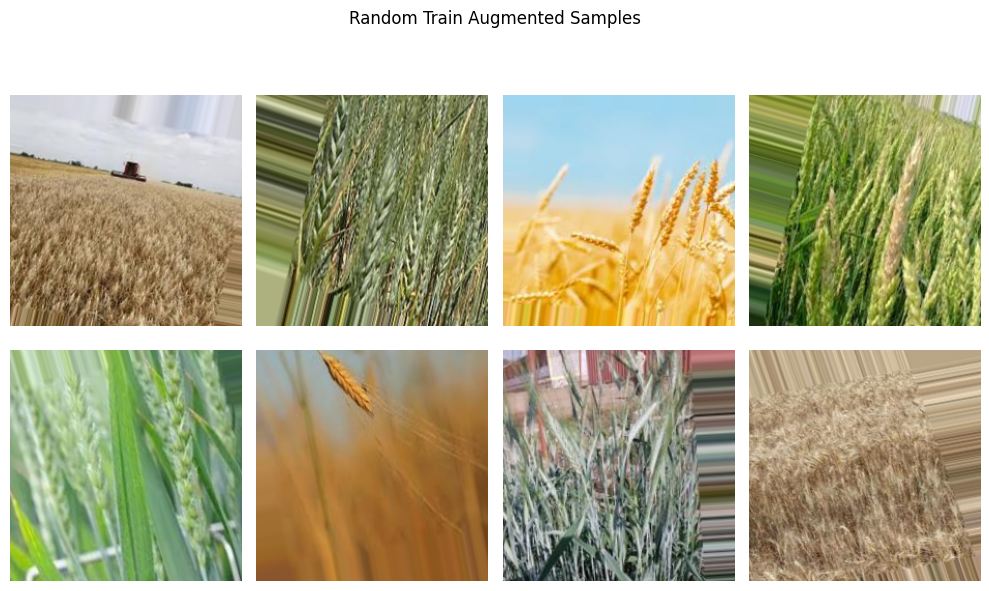

In [ ]:
# Preview a small batch to visually confirm preprocessing/labels
import matplotlib.pyplot as plt
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.suptitle('Random Train Augmented Samples', y=1.02)
plt.tight_layout()
plt.show()


**Compute class weights (for imbalance)**

In [ ]:
# STEP 4: Class weights from training generator

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_train_indices = train_gen.classes  # numeric labels for each sample in train set
classes_ordered = np.unique(y_train_indices)

weights = compute_class_weight(class_weight='balanced',
                               classes=classes_ordered,
                               y=y_train_indices)
class_weights = {int(k): float(v) for k,v in zip(classes_ordered, weights)}
class_weights


{0: 5.754850088183422, 1: 0.8464332036316472, 2: 0.6079746599590088}

**Build a transfer-learning model (pick backbone)**

In [ ]:
# STEP 5: Build a TL model (EfficientNetB0 / ResNet50 / MobileNetV3Small)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

IMG_SHAPE = (224, 224, 3)
NUM_CLASSES = train_gen.num_classes

def build_model(arch='efficientnet', lr=1e-3, dropout=0.3, train_base=False):
    if arch == 'efficientnet':
        base = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
    elif arch == 'resnet50':
        base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
    elif arch == 'mobilenetv3':
        base = tf.keras.applications.MobileNetV3Small(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)
    else:
        raise ValueError("arch must be one of: 'efficientnet', 'resnet50', 'mobilenetv3'")

    base.trainable = train_base  # False for stage-1 (head training)

    inputs = layers.Input(shape=IMG_SHAPE)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base


**Train (stage-1 head) + (stage-2 fine-tune)**

In [ ]:
# STEP 6: Two-stage training with callbacks
import os, tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

CHECK_DIR = f'{PROJECT_ROOT}/checkpoints'
os.makedirs(CHECK_DIR, exist_ok=True)

def train_two_stage(arch='efficientnet', head_epochs=12, ft_epochs=10, ft_unfreeze=20):
    tf.keras.backend.clear_session()

    # --- Stage 1: train head, base frozen ---
    model, base = build_model(arch=arch, lr=1e-3, dropout=0.4, train_base=False)
    ckpt_path = os.path.join(CHECK_DIR, f'{arch}_best.keras')

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
    ]

    hist1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=head_epochs,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # --- Stage 2: fine-tune last N layers of the base ---
    base.trainable = True
    for layer in base.layers[:-ft_unfreeze]:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    hist2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=ft_epochs,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    return model, (hist1, hist2), ckpt_path


In [ ]:
best_model, histories, ckpt = train_two_stage('efficientnet')   # or 'resnet50' / 'mobilenetv3'


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
 97/102 ━━━━━━━━━━━━━━━━━━━━ 49s 10s/step - accuracy: 0.3032 - loss: 1.1537

UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7d2c6c44a390>
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self._standardize_batch(self.py_dataset[i])
                                  ~~~~~~~~~~~~~~~^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py", line 68, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/preprocessing/image.py", line 313, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/image_utils.py", line 236, in load_img
    img = pil_image.open(io.BytesIO(f.read()))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/PIL/Image.py", line 3580, in open
    raise UnidentifiedImageError(msg)

PIL.UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7d2c6c44a390>


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_16426]

In [ ]:
# Scan all split folders and move any non-image / corrupt files to a quarantine folder

import os, shutil
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # try to open truncated files, but we still verify below

PROJECT_ROOT = '/content/drive/MyDrive/Wheat_Leaf_Disease_Project'
SPLITS_ROOT  = f'{PROJECT_ROOT}/splits'
BAD_DIR      = f'{PROJECT_ROOT}/bad_images'
os.makedirs(BAD_DIR, exist_ok=True)

def move_bad(path, reason):
    # Keep a flat quarantine name but preserve some context
    base = path.replace('/', '__')
    dst = os.path.join(BAD_DIR, base)
    try:
        shutil.move(path, dst)
    except Exception:
        # If already exists, remove the original to prevent repeated crashes
        os.remove(path)
    print(f"Moved bad file: {path}  | Reason: {reason}")

def scan_and_clean(root):
    valid_exts = {'.jpg', '.jpeg', '.png'}
    moved = 0
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(root, split)
        for cls in os.listdir(split_dir):
            cls_dir = os.path.join(split_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for fname in os.listdir(cls_dir):
                p = os.path.join(cls_dir, fname)
                if not os.path.isfile(p):
                    continue

                ext = os.path.splitext(fname)[1].lower()
                if ext not in valid_exts:
                    move_bad(p, f'Invalid extension {ext}')
                    moved += 1
                    continue

                if os.path.getsize(p) == 0:
                    move_bad(p, 'Zero-byte file')
                    moved += 1
                    continue

                # Verify that PIL can read the file
                try:
                    with Image.open(p) as im:
                        im.verify()   # quick structural check
                    # Re-open to ensure load works, and force RGB conversion
                    with Image.open(p) as im:
                        _ = im.convert('RGB')
                except Exception as e:
                    move_bad(p, f'PIL error: {e}')
                    moved += 1
    print(f'\nTotal moved to quarantine: {moved}')

scan_and_clean(SPLITS_ROOT)


Moved bad file: /content/drive/MyDrive/Wheat_Leaf_Disease_Project/splits/train/renamed_healthy/resized_resized_healthy_1130.jpg  | Reason: Zero-byte file

Total moved to quarantine: 1


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224,224); batch = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
plain_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(SPLITS_ROOT, 'train'),
    target_size=img_size, batch_size=batch, class_mode='categorical',
    color_mode='rgb', shuffle=True)

val_gen = plain_datagen.flow_from_directory(
    os.path.join(SPLITS_ROOT, 'val'),
    target_size=img_size, batch_size=batch, class_mode='categorical',
    color_mode='rgb', shuffle=False)

test_gen = plain_datagen.flow_from_directory(
    os.path.join(SPLITS_ROOT, 'test'),
    target_size=img_size, batch_size=batch, class_mode='categorical',
    color_mode='rgb', shuffle=False)

print('Class indices:', train_gen.class_indices)


Found 3262 images belonging to 3 classes.
Found 698 images belonging to 3 classes.
Found 701 images belonging to 3 classes.
Class indices: {'renamed_Wheat_Leaf_Rust': 0, 'renamed_Wheat_Loose_Smut': 1, 'renamed_healthy': 2}


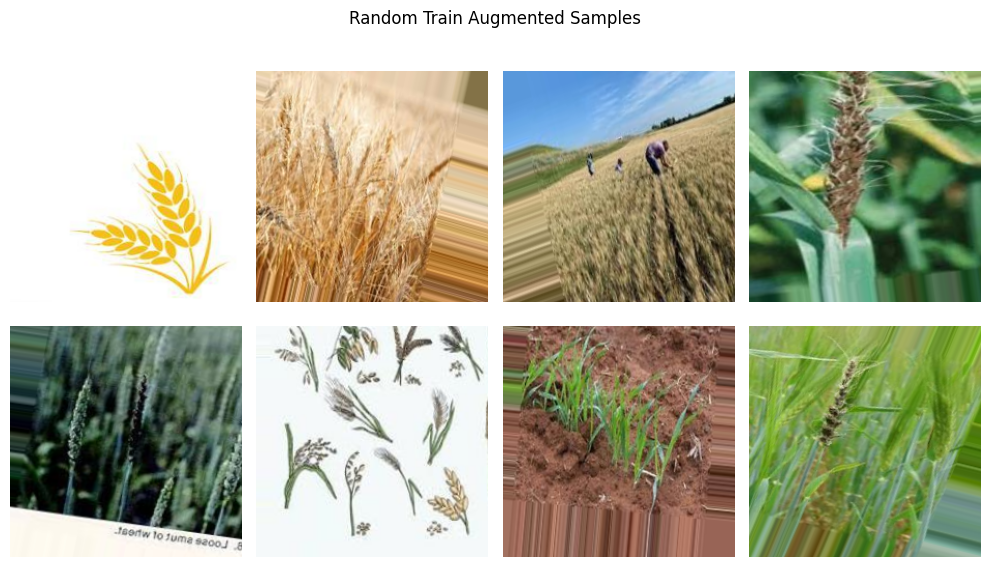

In [ ]:
import matplotlib.pyplot as plt
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1); plt.imshow(x_batch[i]); plt.axis('off')
plt.suptitle('Random Train Augmented Samples'); plt.tight_layout(); plt.show()


In [ ]:
best_model, histories, ckpt = train_two_stage('efficientnet')   # or 'resnet50' / 'mobilenetv3'


Epoch 1/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.3138 - loss: 1.1315 - val_accuracy: 0.0573 - val_loss: 1.1645 - learning_rate: 0.0010
Epoch 2/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.3223 - loss: 1.1095 - val_accuracy: 0.0573 - val_loss: 1.1831 - learning_rate: 0.0010
Epoch 3/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 326s 3s/step - accuracy: 0.3049 - loss: 1.1225 - val_accuracy: 0.3940 - val_loss: 1.0882 - learning_rate: 0.0010
Epoch 4/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 362s 4s/step - accuracy: 0.2772 - loss: 1.1675 - val_accuracy: 0.0573 - val_loss: 1.2187 - learning_rate: 0.0010
Epoch 5/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.2735 - loss: 1.1568 - val_accuracy: 0.5487 - val_loss: 1.0865 - learning_rate: 0.0010
Epoch 6/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 348s 3s/step - accuracy: 0.3375 - loss: 1.0888 - val_accuracy: 0.3940 - val_loss: 1.1192 - learning_rate: 0.0010
Epoch 7/12
102/102 ━━━━━━━━━━━━━━━━━━━━ 360s 4s/step - accuracy: 0.3687 - loss: 1.

In [ ]:
# EVALUATION HELPERS: classification report + confusion matrices (raw & normalized)
import os, math, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

OUT_DIR = f'{PROJECT_ROOT}/figures'
os.makedirs(OUT_DIR, exist_ok=True)

def _plot_cm(cm, class_names, title, normalize=False, save_path=None):
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-9)
    plt.figure(figsize=(5.5,4.5))
    plt.imshow(cm, cmap='Blues')
    plt.title(title); plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha='right')
    plt.yticks(ticks, class_names)
    thresh = (cm.max() + cm.min()) / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j] if not normalize else f"{cm[i, j]*100:.1f}%"
            plt.text(j, i, val, ha='center', va='center',
                     color='white' if (cm[i, j] > thresh) else 'black', fontsize=9)
    plt.ylabel('True'); plt.xlabel('Predicted')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

def evaluate_generator(model, generator, name='val'):
    # Class names in correct index order
    idx_to_class = {v:k for k,v in generator.class_indices.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    # Predict all samples
    steps = math.ceil(generator.samples / generator.batch_size)
    y_prob = model.predict(generator, steps=steps, verbose=1)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = generator.classes[:len(y_pred)]

    # Reports
    print(f"\n=== {name.upper()} SET — CLASSIFICATION REPORT ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name.capitalize()} Macro F1: {macro_f1:.4f}")

    # Confusion matrices (raw & normalized)
    cm = confusion_matrix(y_true, y_pred)
    raw_path = os.path.join(OUT_DIR, f'cm_{name}_raw.png')
    norm_path = os.path.join(OUT_DIR, f'cm_{name}_normalized.png')
    _plot_cm(cm, class_names, title=f'{name.capitalize()} Confusion Matrix (counts)', normalize=False, save_path=raw_path)
    _plot_cm(cm, class_names, title=f'{name.capitalize()} Confusion Matrix (row-normalized)', normalize=True, save_path=norm_path)

    print(f"Saved figures to:\n  {raw_path}\n  {norm_path}")


22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step

=== VAL SET — CLASSIFICATION REPORT ===
                          precision    recall  f1-score   support

 renamed_Wheat_Leaf_Rust     0.0000    0.0000    0.0000        40
renamed_Wheat_Loose_Smut     1.0000    0.0145    0.0287       275
         renamed_healthy     0.5519    1.0000    0.7112       383

                accuracy                         0.5544       698
               macro avg     0.5173    0.3382    0.2466       698
            weighted avg     0.6968    0.5544    0.4016       698

Val Macro F1: 0.2466


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


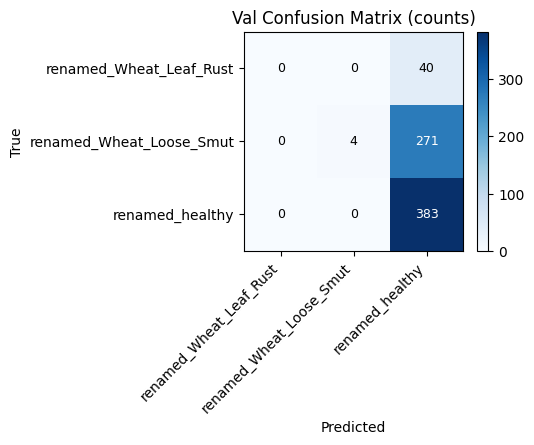

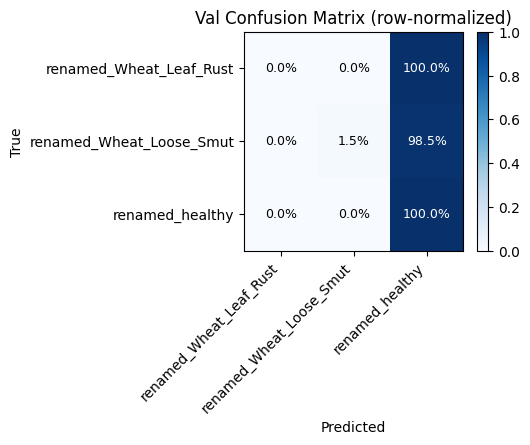

Saved figures to:
  /content/drive/MyDrive/Wheat_Leaf_Disease_Project/figures/cm_val_raw.png
  /content/drive/MyDrive/Wheat_Leaf_Disease_Project/figures/cm_val_normalized.png


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step

=== TEST SET — CLASSIFICATION REPORT ===
                          precision    recall  f1-score   support

 renamed_Wheat_Leaf_Rust     0.0000    0.0000    0.0000        41
renamed_Wheat_Loose_Smut     1.0000    0.0109    0.0215       276
         renamed_healthy     0.5501    1.0000    0.7098       384

                accuracy                         0.5521       701
               macro avg     0.5167    0.3370    0.2438       701
            weighted avg     0.6951    0.5521    0.3973       701

Test Macro F1: 0.2438


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


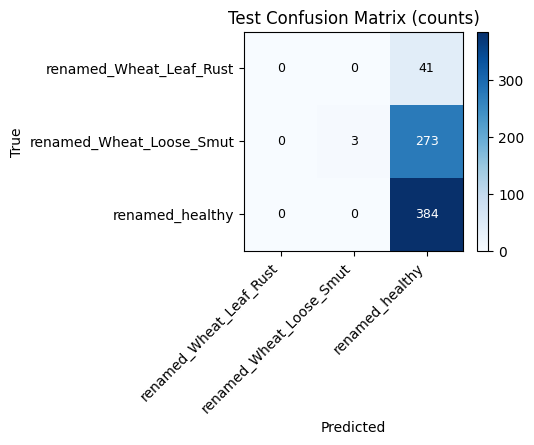

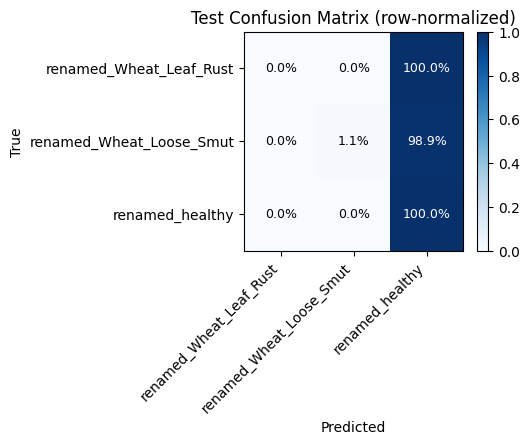

Saved figures to:
  /content/drive/MyDrive/Wheat_Leaf_Disease_Project/figures/cm_test_raw.png
  /content/drive/MyDrive/Wheat_Leaf_Disease_Project/figures/cm_test_normalized.png


In [ ]:
# Evaluate on VALIDATION
evaluate_generator(best_model, val_gen, name='val')

# Evaluate on TEST (final number to report)
evaluate_generator(best_model, test_gen, name='test')
